# Objective
This assignment goal is to allow students to be creative on how to use tools that we have just learnt in the class to maximize his or her profit. There are two goals that students should achieve
1. Understand the uses of ARMA, ARIMA, ARCH and GRACH Models
2. Develop his or her trading strategy to maximize his or her gain.

## Import and Install related libraies

In [ ]:
!pip install yfinance
!pip install arch
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import itertools    
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import arch
from typing import Union, Any, Tuple, Literal
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ARIMA Seach Module

In [ ]:
def arimaParameterSearch(data:pd.Series, ## input date
                         pq_order:int =2, # maximum AR and MA orders
                         d_order: int =1 # maximum d order
                         ) -> Tuple[float, tuple, callable]:
                         # aic value, (p,d,q), result of model
  p = q = range(pq_order) # p =q = [0,1,..., pq_order-1]
  d = range(d_order) # d = [0,1,..., d_order-1]
  parameter_spaces = list(itertools.product(p, d, q)) 
  # all possible pairs of (p, d, q)
  best_aic, pdq= None, None
  best_result = None
  for (p, d, q) in parameter_spaces:   # for each pair
    try :
      model = SARIMAX(data, order=(p,d,q), trend="c") # initialize model
      result = model.fit() # find best parameters
      if (best_aic is None) or (result.aic < best_aic): # if aic is smaller
        best_aic = result.aic # update model, aic, and pqq
        pdq = (p,d,q)
        best_result = result
    except:
      continue
  return best_aic, pdq, best_result

## ARCH Seach Module

In [ ]:
from arch.univariate.base import ARCHModel, ARCHModelResult
warnings.filterwarnings("ignore")
def buildArch(data:pd.Series, # input date
              p_max:int=10, # maximum arch terms
              mean_type:Literal["zero","constant","AR"]="constant" # possible mean function
              ) -> Tuple[ARCHModelResult, ARCHModel, int]:
              # result from model fit and the model
  best_aic = 1e200
  best_model = None
  best_result = None
  for p in range(1, p_max): # for p from 1 to p_max -1 
    for lag in range(p):
      model = arch_model(data, 
                         mean=mean_type,                         
                         p=p, 
                         q=0, 
                         vol="ARCH")
      try:
        result = model.fit(disp=False)
        aic = result.aic
        if aic < best_aic:
          best_aic = aic
          best_model = model
          best_result = result
          best_p = p
      except:
        continue      
  return best_result, best_model, best_p


## GARCH Seach Module

In [ ]:
def buildGArch(data:pd.Series, # input date
               p_max:int=10, # maximum residue terms,
               q_max:int=10, # maximum sigma terms
               mean_type:Literal["zero","constant","AR"]="constant" # possible mean function
               ) -> Tuple[ARCHModelResult, ARCHModel, tuple]:
  best_aic = 1e200
  best_model = None
  best_result = None
  p_list = range(1, p_max)
  q_list = range(0, q_max)
  pq_garch = (0,0)
  parameter_spaces = list(itertools.product(p_list, q_list)) 
  for (p, q) in parameter_spaces:
    model = arch_model(data, mean=mean_type,
                       p=p, q=q, vol="GARCH")
    try:
      result = model.fit(disp=False)
      aic = result.aic
      if aic < best_aic:
        best_aic = aic
        best_model = model
        best_result = result
        pq_garch  =(p,q)
    except:
      continue      
  return best_result, best_model, pq_garch

## Action and Status Module

In [ ]:
class Status:
  HOLD = "HOLD"
  NO_POSITION = "NO POSITION"
class Action:
  BUY = "BUY"
  SELL = "SELL"
  KEEP_POSITION = "KEEP POSITION"

## Decision Module

Here, I used the fact that rapid change in price may cause by the market participation. 
 1. Buy if the upper bound price (highest_price ) is lower than current price. The rapid increase in the current price comparing to the forecasted upper bound value show that the market rushes to buy bitcoin and the price should continue to move up. 
 2. Sell if the lower bound price (lowest_pice) is higher than current price or buy_price is lower than 95% of current_price. (set maximum loss at 95%). Rapid decrease in current price comparing to lower bound price shows that market moves away from the bitcoin.

In [ ]:
def makeDecisionARIMA(data: pd.Series, # hist_price
                      current_price: float, # current_price
                      buy_price:float, # last_buy_price
                      status: str, # hold or no position
                      pq:Union[tuple,int], # tuple for fix size and int to search for optm. param
                      d:int, # either the integration term or maximum search value
                      look_forward:int=1 # how far into the future
                      ) -> str: # BUY or SELL or KEEP Position

  if isinstance(pq, int): # find model orders if only interger is given
    *_, result = arimaParameterSearch(data, pq_order=pq,d_order= d)
  else:
    p,q = pq
    model = SARIMAX(data, order=(p,d,q), trend="c")
    result = model.fit()
  forecaster = result.get_forecast(step=look_forward, alpha=0.05) 
  # forecast to look_forward step with 1-alpha confidence level (1-0.05=0.95% )
  confidence_interval = forecaster.conf_int()   
  lowest_price = confidence_interval.min().iloc[0]
  highest_price = confidence_interval.max().iloc[1]
  if status == Status.NO_POSITION: 
    if current_price > highest_price: 
      # buy if current price is higher than higher conf.
      return Action.BUY
    else:
      return Action.KEEP_POSITION
  elif status == Status.HOLD: 
    if (buy_price < current_price + np.log(0.95)) or (current_price < lowest_price): 
      # sell if current  is lower than lower conf or 
      # buy_price is lower than 95 % current_price. Note buy_price and current price are in log-scale.  
      return Action.SELL
    else:
      return Action.KEEP_POSITION

## Trade simulation


In [ ]:
import sys
def tradeSimulation(data,  # all data
                    pq_order:Union[int, tuple], # pq order
                    d_order:int, # d order
                    hist_len:int = 100, # look back time
                    look_forward:int=1, # look forward time scale
                    init_wealth:float = 1_000_000 # initial investment
                    ) -> Tuple[pd.Series]: #time-series of
                    # cash, stock, port_size, actions
  
  current_cash = init_wealth # start with all cach
  current_stock = 0
  buy_price = 0
  port_size = pd.Series()
  cash = pd.Series()
  stock = pd.Series()
  status = Status.NO_POSITION       
  actions = pd.Series()         
  for k, date in enumerate(data.index): # for each day
    current_price = data[date] # get current price
    if k < hist_len:    # do we have enough data to make model
      actions[date] = 0 # no
      action = Action.KEEP_POSITION # do nothing
    else:
      data_k = np.log(data.iloc[k-hist_len:k]) # get historical data
      action = makeDecisionARIMA(data_k, # we use log price here to fit linear model
                                 current_price=np.log(current_price),
                                 buy_price= np.log(buy_price),
                                 status=status, pq=pq_order,
                                 d=d_order, look_forward=look_forward)
      # make decision to Buy, SELL or Keep position
      if (action == Action.BUY) and (status == Status.NO_POSITION):
        buy_price = data[date]
        current_stock = current_cash / buy_price 
        current_cash = 0
        status = Status.HOLD
        actions[date] = 1
      elif (action == Action.SELL) and (status == Status.HOLD):
        sell_price = data[date]
        current_cash = sell_price * current_stock 
        current_stock = 0 
        status = Status.NO_POSITION     
        actions[date] = -1 
      else:
        actions[date] = 0
    cash[date] = current_cash 
    stock[date] = current_stock
    port_size[date] = current_cash + current_stock * data[date]
    text = f"{date}: Cash {current_cash:0.2f}, Stock: {current_stock:0.2f},"
    text += f" port_size: {port_size[date]:0.2f}, ACTION: {action}"
    sys.stdout.write("\r" + text)
    sys.stdout.flush()
  return cash, stock, port_size, actions

## Example trade and performance metrics

In [ ]:
df_btc = yf.download("BTC-USD", start="2019-01-01", end="2022-12-31")
df_btc_close = df_btc.Close
log_close = np.log(df_btc_close)
best_aic, pdq, result = arimaParameterSearch(np.log(df_btc_close), pq_order=4,d_order=2)
print(pdq)

[*********************100%***********************]  1 of 1 completed
(1, 1, 1)


In [ ]:
cash, stock, port_size, actions = tradeSimulation(df_btc_close, 
                                                  pq_order=(pdq[0],pdq[-1]), 
                                                  d_order=pdq[1], 
                                                  hist_len=100, 
                                                  look_forward=5,
                                                  init_wealth=1_000_000)

2022-12-30 00:00:00: Cash 0.00, Stock: 76.90, port_size: 1276705.69, ACTION: KEEP POSITION

Text(0, 0.5, 'Gain/Loss (%)')

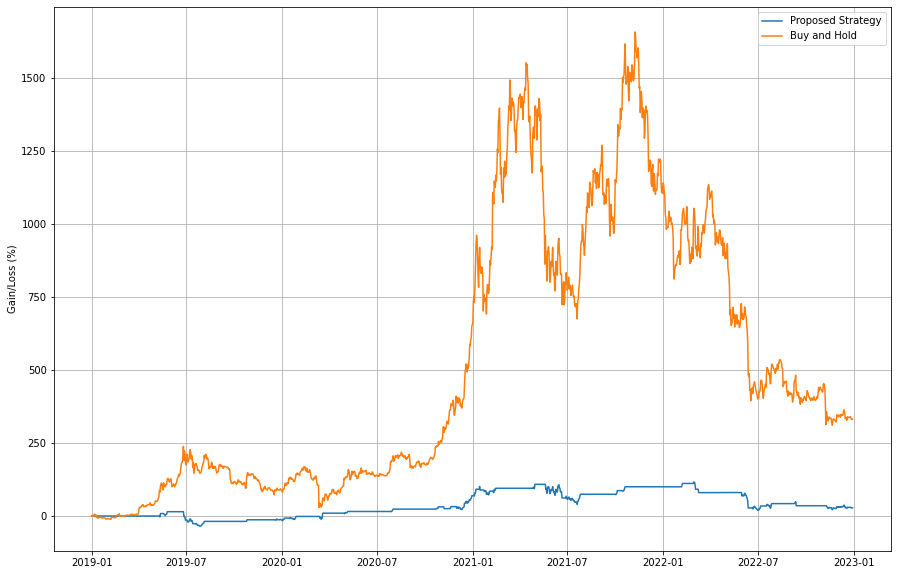

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.plot(df_btc_close*100/df_btc_close.iloc[0] - 100, label="Buy and Hold")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Gain/Loss (%)')

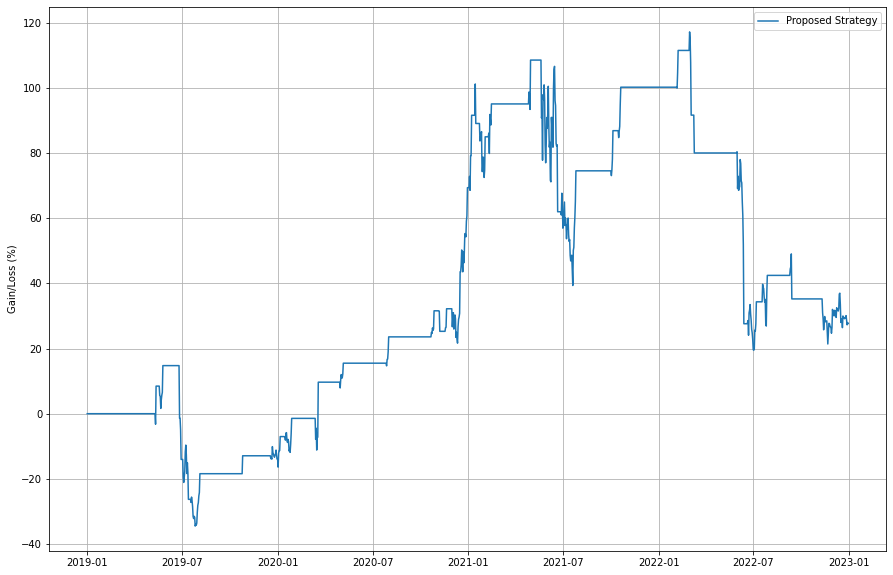

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Port Size (USD)')

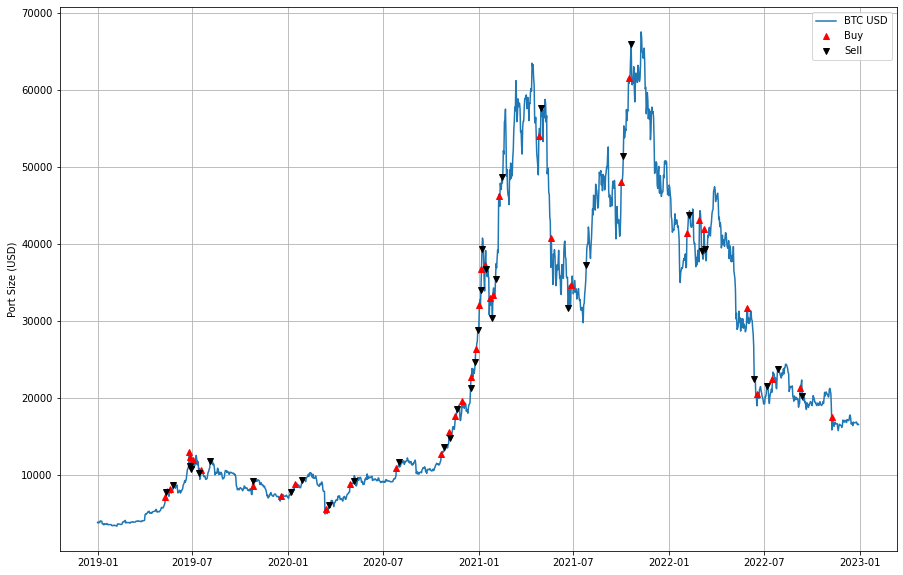

In [ ]:
plt.figure(figsize=(15,10))
Buys = df_btc_close[actions==1]
Sells = df_btc_close[actions==-1]
plt.plot(df_btc_close, label="BTC USD")
plt.plot(Buys, label="Buy", marker="^", color="red", linestyle = 'None')
plt.plot(Sells, label="Sell", marker="v", color="black", linestyle = 'None')
plt.legend()
plt.grid()
plt.ylabel("Port Size (USD)")

In [ ]:
def getPeformanceValue(port_size:pd.Series):
  total_return = (port_size.iloc[-1]/port_size.iloc[0] - 1)
  peak = port_size.max()
  max_date = port_size.index[port_size==peak]
  max_date = max_date.min()
  filtered_port_size = port_size[max_date:]
  mdd = 1.0 - filtered_port_size.min()/peak
  port_return = port_size.pct_change(1).dropna()
  sharpe_ratio = port_return.mean()/ port_return.std()
  sharpe_ratio *= np.sqrt(365) # scale to annum
  return total_return, mdd, sharpe_ratio

total_return, mdd, sharpe_ratio =  getPeformanceValue(port_size)
print(f"The perfomance values of my strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")

total_return, mdd, sharpe_ratio =  getPeformanceValue(df_btc_close)
print(f"The perfomance values of buy and hold strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")


The perfomance values of my strategy are: 
    Total Return: 27.67%
    Maximum Drawn Down: 45.00%
    Sharpe Ratio: 0.350
The perfomance values of buy and hold strategy are: 
    Total Return: 331.96%
    Maximum Drawn Down: 76.63%
    Sharpe Ratio: 0.877


# Main Question:
You will trade on less volatile security, namely, Gold future. Find the best strategy to trade on Gold Future from 2019-01-01 to 2022-12-31
Score will be based on
 1. 10 Points to the highest total return at end of 2022.
 2. 10 Points to the lowest maximum drawn down
 3. 10 Points to the highest Sharpe Ratio
 4. 20 Points if you will over the buy and hold strategy in the total return.
 5. 50 Points for the code and the explanation on the strategy

Here, I will rank each scores from the best to the worst where the best get 10 points and worst get 0. If there are more than one people on the same sport both with fill the lower rank.

For example, if all students get the same return, all will be set at the lowest rank (0 Points).

You can use any of these models, ARIMA, or ARIMA + ARCH or ARIMA + GARCH

In [ ]:
from scipy.stats import norm
def confidence_interval(arch_result, alpha=0.05, h=1, start_date=None):
  forecast = arch_result.forecast(horizon=h, start=start_date)
  forecast_mean = forecast.mean.dropna()
  forecast_var = forecast.residual_variance.dropna()
  z = norm.ppf(1-alpha/2)
  low_conf = forecast_mean - z* np.sqrt(forecast_var)
  high_conf = forecast_mean + z* np.sqrt(forecast_var)
  return low_conf, high_conf

def makeDecisionARIMA_v1_Nisut(data: pd.Series, # hist_price
                      current_price: float, # current_price
                      buy_price:float, # last_buy_price
                      status: str, # hold or no position
                      pq:Union[tuple,int], # tuple for fix size and int to search for optm. param
                      d:int, # either the integration term or maximum search value
                      look_forward:int=1 # how far into the future
                      ) -> str: # BUY or SELL or KEEP Position
  if isinstance(pq, int): # find model orders if only interger is given
    result,*_ = buildGArch(data = data, p_max = pq[0],q_max = pq[1],mean_type = "constant")
  else:
    p,q = pq
    model = arch_model(data, mean="constant",p=p, q=q, vol="GARCH")
    result = model.fit()
  forecaster = result.forecast(horizon = 1) 
  # forecast_mean = forecaster.mean.dropna()
  # forecast_var = np.sqrt(forecaster.residual_variance["h.1"].dropna().iloc[-1])
  # z = norm.ppf(1-0.05/2)
  # lowest_price = forecast_mean - z* forecast_var
  # highest_price = forecast_mean + z* forecast_var

  low_conf, high_conf = confidence_interval(result, alpha=0.05, h=1)
  lowest_price = low_conf['h.1'][0]
  highest_price = high_conf['h.1'][0]
  print(f"current_price = {current_price}")

  if status == Status.NO_POSITION: 
    if current_price > highest_price: 
      # buy if current price is higher than higher conf.
      return Action.BUY
    else:
      return Action.KEEP_POSITION
  elif status == Status.HOLD: 
    if (buy_price < current_price + np.log(0.80)) or (current_price < lowest_price): 
      # sell if current  is lower than lower conf or 
      # buy_price is lower than 80 % current_price. Note buy_price and current price are in log-scale.  
      return Action.SELL
    else:
      return Action.KEEP_POSITION

In [ ]:
def tradeSimulation_V1_Nisit(data,  # all data
                    pq_order:Union[int, tuple], # pq order
                    d_order:int, # d order
                    hist_len:int = 100, # look back time
                    look_forward:int=1, # look forward time scale
                    init_wealth:float = 1_000_000 # initial investment
                    ) -> Tuple[pd.Series]: #time-series of
                    # cash, stock, port_size, actions
  
  current_cash = init_wealth # start with all cach
  current_stock = 0
  buy_price = 0
  port_size = pd.Series()
  cash = pd.Series()
  stock = pd.Series()
  status = Status.NO_POSITION       
  actions = pd.Series()         
  for k, date in enumerate(data.index): # for each day
    current_price = data[date] # get current price
    if k < hist_len:    # do we have enough data to make model
      actions[date] = 0 # no
      action = Action.KEEP_POSITION # do nothing
    else:
      data_k = np.log(data.iloc[k-hist_len:k]) # get historical data
      action = makeDecisionARIMA_v1_Nisut(data_k, # we use log price here to fit linear model
                                 current_price=np.log(current_price),
                                 buy_price= np.log(buy_price),
                                 status=status, pq=pq_order,
                                 d=d_order, look_forward=look_forward)
      # make decision to Buy, SELL or Keep position
      if (action == Action.BUY) and (status == Status.NO_POSITION):
        buy_price = data[date]
        current_stock = current_cash / buy_price 
        current_cash = 0
        status = Status.HOLD
        actions[date] = 1
      elif (action == Action.SELL) and (status == Status.HOLD):
        sell_price = data[date]
        current_cash = sell_price * current_stock 
        current_stock = 0 
        status = Status.NO_POSITION     
        actions[date] = -1 
      else:
        actions[date] = 0
    cash[date] = current_cash 
    stock[date] = current_stock
    port_size[date] = current_cash + current_stock * data[date]
    text = f"{date}: Cash {current_cash:0.2f}, Stock: {current_stock:0.2f},"
    text += f" port_size: {port_size[date]:0.2f}, ACTION: {action}"
    sys.stdout.write("\r" + text)
    sys.stdout.flush()
  return cash, stock, port_size, actions

In [ ]:
df_gold = yf.download("GC=F", start="2019-01-01", end="2022-12-31")
df_gold_close = df_gold.Close

[*********************100%***********************]  1 of 1 completed


In [ ]:

#df_btc_close = df_gold.Close
log_close = np.log(df_gold_close)
#best_aic, pdq, result = arimaParameterSearch(log_close, pq_order=2,d_order=1)
best_result, best_model, pq = buildGArch(log_close, p_max=6, q_max=6,mean_type="constant") 
print(pq)

(2, 5)


In [ ]:
cash, stock, port_size, actions = tradeSimulation_V1_Nisit(df_gold_close, 
                                                  pq_order=(pq[0],pq[-1]), 
                                                  d_order=0, 
                                                  hist_len=100, 
                                                  look_forward=5,
                                                  init_wealth=1_000_000)

2019-05-24 00:00:00: Cash 1000000.00, Stock: 0.00, port_size: 1000000.00, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 3995388165.211768
Iteration:      2,   Func. Count:     27,   Neg. LLF: 589384.4663612667
Iteration:      3,   Func. Count:     42,   Neg. LLF: -304.8591878572459
Optimization terminated successfully    (Exit mode 0)
            Current function value: -304.8591881228984
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 3
current_price = 7.151877236681538
2019-05-28 00:00:00: Cash 1000000.00, Stock: 0.00, port_size: 1000000.00, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 3845333793.0467205
Iteration:      2,   Func. Count:     27,   Neg. LLF: 317488.2649889415
Iteration:      3,   Func. Count:     42,   Neg. LLF: 265.4233642333081
Iteration:      4,   Func. Count:     55,   Neg. LLF: 41903.38581862895
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1557080.

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


current_price = 7.2507774118175465
2019-07-16 00:00:00: Cash 0.00, Stock: 756.03, port_size: 1065396.54, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 181376691.72116023
Iteration:      2,   Func. Count:     28,   Neg. LLF: 12454815.839697516
Iteration:      3,   Func. Count:     43,   Neg. LLF: -243.89924012602873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -243.899240645985
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 3
current_price = 7.259327259099518
2019-07-17 00:00:00: Cash 0.00, Stock: 756.03, port_size: 1074544.57, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 249604413.22897932
Iteration:      2,   Func. Count:     28,   Neg. LLF: 15899135.430531954
Iteration:      3,   Func. Count:     44,   Neg. LLF: 142805.62198606934
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1603750.7473499372
Iteration:      5,   Func. Cou

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     22,   Func. Count:    330,   Neg. LLF: 2.635953641229789
Iteration:     23,   Func. Count:    341,   Neg. LLF: -120.99542519137697
Iteration:     24,   Func. Count:    352,   Neg. LLF: -172.9167870201403
Iteration:     25,   Func. Count:    363,   Neg. LLF: -173.7488037179621
Iteration:     26,   Func. Count:    373,   Neg. LLF: -173.77278482988197
Iteration:     27,   Func. Count:    383,   Neg. LLF: -173.77358040642255
Iteration:     28,   Func. Count:    393,   Neg. LLF: -173.77378065250147
Iteration:     29,   Func. Count:    403,   Neg. LLF: -173.7739643762649
Iteration:     30,   Func. Count:    412,   Neg. LLF: -173.77396371515192
Optimization terminated successfully    (Exit mode 0)
            Current function value: -173.7739643762649
            Iterations: 34
            Function evaluations: 412
            Gradient evaluations: 30
current_price = 7.314685946747501
2019-09-09 00:00:00: Cash 0.00, Stock: 756.03, port_size: 1135707.27, ACTION: KEEP POSITIONIte

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 793452726874011.5
Iteration:      2,   Func. Count:     26,   Neg. LLF: 1026.8125249195125
Iteration:      3,   Func. Count:     37,   Neg. LLF: -173.66509349802075
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3944704822392213.0
Iteration:      5,   Func. Count:     63,   Neg. LLF: 4751753060219699.0
Iteration:      6,   Func. Count:     80,   Neg. LLF: 15363378517.3322
Iteration:      7,   Func. Count:     93,   Neg. LLF: 3238778.1881904863
Iteration:      8,   Func. Count:    108,   Neg. LLF: -181.73146717010883
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.73146767568258
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
current_price = 7.311351943417312
2019-10-08 00:00:00: Cash 0.00, Stock: 756.03, port_size: 1131927.12, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 936139051884084.5
Iteration

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     40,   Neg. LLF: 1338727559518644.5
Iteration:      4,   Func. Count:     55,   Neg. LLF: -267.0522878603079
Optimization terminated successfully    (Exit mode 0)
            Current function value: -267.05228868753545
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 4
current_price = 7.349423763445181
2020-01-22 00:00:00: Cash 0.00, Stock: 756.03, port_size: 1175852.50, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 64546334.383808754
Iteration:      2,   Func. Count:     27,   Neg. LLF: -276.7950677274187
Iteration:      3,   Func. Count:     37,   Neg. LLF: -246.6810877111089
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.415205355458453e+17
Iteration:      5,   Func. Count:     64,   Neg. LLF: -22.629611211723127
Iteration:      6,   Func. Count:     78,   Neg. LLF: 48354572.19941442
Iteration:      7,   Func. Count:     89,   Neg. LLF: -279.4657181472182
Iterat

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:     80,   Neg. LLF: 3818576543419.9463
Iteration:      7,   Func. Count:     94,   Neg. LLF: -207.05569126372095
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.05569184556688
            Iterations: 11
            Function evaluations: 94
            Gradient evaluations: 7
current_price = 7.5323559170069725
2021-05-17 00:00:00: Cash 1583747.31, Stock: 0.00, port_size: 1583747.31, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 740564.1681042418
Iteration:      2,   Func. Count:     26,   Neg. LLF: 245391.56159009208
Iteration:      3,   Func. Count:     37,   Neg. LLF: -104.2556379139147
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3634718.6872028457
Iteration:      5,   Func. Count:     62,   Neg. LLF: -209.23927630721752
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.23927671485347
            Iterations: 9
            

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     40,   Neg. LLF: -206.02101636181519
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.02101683839552
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 3
current_price = 7.48206262940798
2021-07-01 00:00:00: Cash 1583747.31, Stock: 0.00, port_size: 1583747.31, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 66015649.891328156
Iteration:      2,   Func. Count:     26,   Neg. LLF: 22156.95664370486
Iteration:      3,   Func. Count:     40,   Neg. LLF: -206.64138392602024
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.6413844246305
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 3
current_price = 7.485828238000856
2021-07-02 00:00:00: Cash 1583747.31, Stock: 0.00, port_size: 1583747.31, ACTION: KEEP POSITIONIteration:      1,   Func. Count:

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 142491079.7701657
Iteration:      2,   Func. Count:     28,   Neg. LLF: 778314.6491797297
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2492.336378489267
Iteration:      4,   Func. Count:     58,   Neg. LLF: 864.1008229432146
Iteration:      5,   Func. Count:     72,   Neg. LLF: 296.46307888753023
Iteration:      6,   Func. Count:     86,   Neg. LLF: 16057033.523297833
Iteration:      7,   Func. Count:    102,   Neg. LLF: 281.3246859764934
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1112057.9972050781
Iteration:      9,   Func. Count:    130,   Neg. LLF: -237.12134973147624
Optimization terminated successfully    (Exit mode 0)
            Current function value: -237.1213503671156
            Iterations: 13
            Function evaluations: 130
            Gradient evaluations: 9
current_price = 7.564342178907116
2022-03-18 00:00:00: Cash 0.00, Stock: 857.19, port_size: 1652836.94, ACTION: KEEP POSITIONIteration:  

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Iteration:     12,   Func. Count:    154,   Neg. LLF: -221.886507428139
Optimization terminated successfully    (Exit mode 0)
            Current function value: -221.88650764559443
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 12
current_price = 7.451996364621614
2022-07-12 00:00:00: Cash 0.00, Stock: 857.19, port_size: 1477198.45, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 253598.2671620573
Iteration:      2,   Func. Count:     25,   Neg. LLF: -102.57517513313314
Iteration:      3,   Func. Count:     36,   Neg. LLF: 1554752.8174030764
Iteration:      4,   Func. Count:     51,   Neg. LLF: 22528.94350880883
Iteration:      5,   Func. Count:     65,   Neg. LLF: -207.5840824875304
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.58408307726347
            Iterations: 9
            Function evaluations: 65
            Gradient evaluations: 5
current_price = 7

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 1169169.7414196539
Iteration:      2,   Func. Count:     26,   Neg. LLF: -125.340647061661
Iteration:      3,   Func. Count:     37,   Neg. LLF: -205.0984560617527
Iteration:      4,   Func. Count:     48,   Neg. LLF: 44512.47634683056
Iteration:      5,   Func. Count:     60,   Neg. LLF: -118.7337805643981
Iteration:      6,   Func. Count:     71,   Neg. LLF: -209.6220372703626
Iteration:      7,   Func. Count:     82,   Neg. LLF: -210.46182062879896
Iteration:      8,   Func. Count:     93,   Neg. LLF: -158.1512151143114
Iteration:      9,   Func. Count:    105,   Neg. LLF: 70603.29877533855
Iteration:     10,   Func. Count:    120,   Neg. LLF: 1818.521015402219
Iteration:     11,   Func. Count:    131,   Neg. LLF: 1005.7648826497
Iteration:     12,   Func. Count:    145,   Neg. LLF: 204.06870643430022
Iteration:     13,   Func. Count:    159,   Neg. LLF: -213.90129837395187
Iteration:     14,   Func. Count:    169,   Neg. LLF: -2

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    116,   Neg. LLF: -204.2395890643525
Iteration:     10,   Func. Count:    127,   Neg. LLF: -200.85058059536019
Iteration:     11,   Func. Count:    138,   Neg. LLF: 56.12479774721187
Iteration:     12,   Func. Count:    151,   Neg. LLF: -124.37727510858394
Iteration:     13,   Func. Count:    163,   Neg. LLF: 62801456796269.984
Iteration:     14,   Func. Count:    177,   Neg. LLF: -217.7254162444812
Optimization terminated successfully    (Exit mode 0)
            Current function value: -217.72541687141023
            Iterations: 18
            Function evaluations: 177
            Gradient evaluations: 14
current_price = 7.4189608598521595
2022-10-10 00:00:00: Cash 1429195.72, Stock: 0.00, port_size: 1429195.72, ACTION: SELLIteration:      1,   Func. Count:     11,   Neg. LLF: 9162607.21251501
Iteration:      2,   Func. Count:     26,   Neg. LLF: 1460372120.1890852
Iteration:      3,   Func. Count:     38,   Neg. LLF: 1694632.7903203806
Iteration: 

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:     86,   Neg. LLF: 3808125.749479706
Iteration:      8,   Func. Count:    101,   Neg. LLF: 176132.7753033109
Iteration:      9,   Func. Count:    116,   Neg. LLF: 1194.1633621589176
Iteration:     10,   Func. Count:    127,   Neg. LLF: 324.6588493894439
Iteration:     11,   Func. Count:    140,   Neg. LLF: -104.87256104268505
Iteration:     12,   Func. Count:    152,   Neg. LLF: 5790719.59325443
Iteration:     13,   Func. Count:    167,   Neg. LLF: -221.42388132776748
Optimization terminated successfully    (Exit mode 0)
            Current function value: -221.42388179831923
            Iterations: 17
            Function evaluations: 167
            Gradient evaluations: 13
current_price = 7.416979621381154
2022-10-26 00:00:00: Cash 1429195.72, Stock: 0.00, port_size: 1429195.72, ACTION: KEEP POSITIONIteration:      1,   Func. Count:     11,   Neg. LLF: 2077001.0708871759
Iteration:      2,   Func. Count:     26,   Neg. LLF: 54614478.918110706
Itera

Text(0, 0.5, 'Gain/Loss (%)')

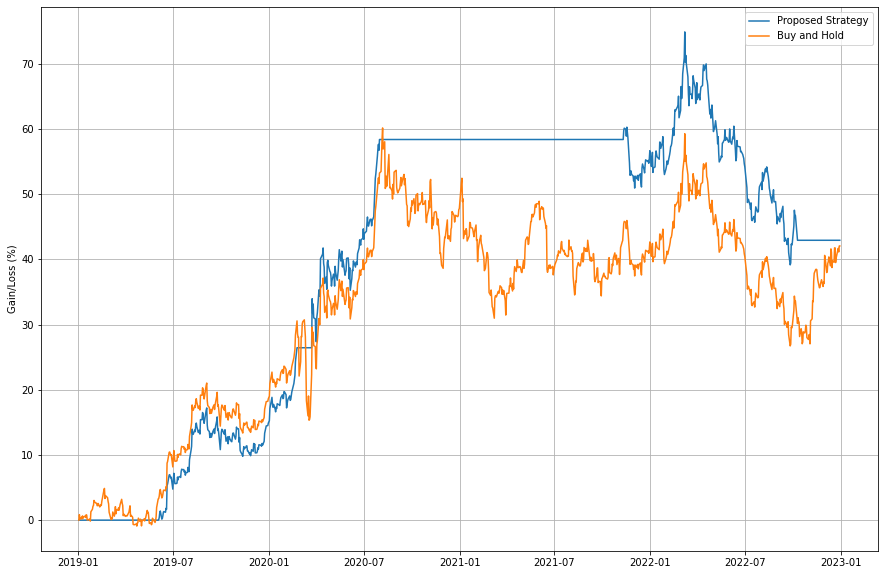

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.plot(df_gold_close*100/df_gold_close.iloc[0] - 100, label="Buy and Hold")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Gain/Loss (%)')

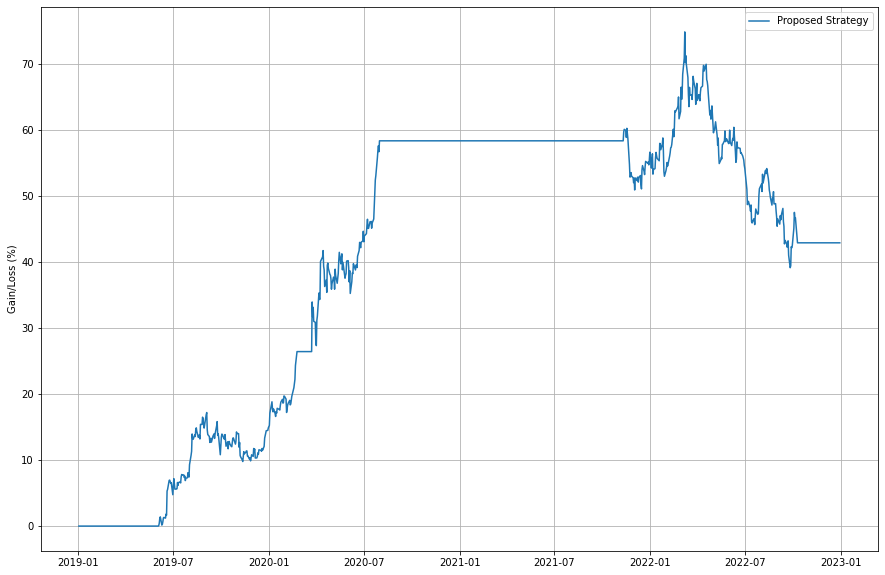

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Port Size (USD)')

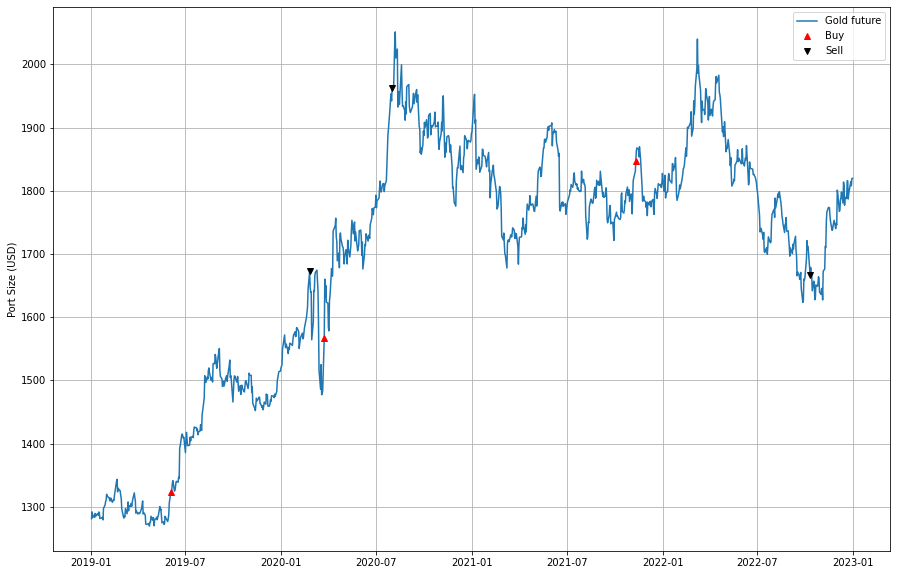

In [ ]:
plt.figure(figsize=(15,10))
Buys = df_gold_close[actions==1]
Sells = df_gold_close[actions==-1]
plt.plot(df_gold_close, label="Gold future")
plt.plot(Buys, label="Buy", marker="^", color="red", linestyle = 'None')
plt.plot(Sells, label="Sell", marker="v", color="black", linestyle = 'None')
plt.legend()
plt.grid()
plt.ylabel("Port Size (USD)")

In [ ]:
total_return, mdd, sharpe_ratio =  getPeformanceValue(port_size)
print(f"The perfomance values of my strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")

total_return, mdd, sharpe_ratio =  getPeformanceValue(df_gold_close)
print(f"The perfomance values of buy and hold strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")

The perfomance values of my strategy are: 
    Total Return: 42.92%
    Maximum Drawn Down: 20.43%
    Sharpe Ratio: 1.053
The perfomance values of buy and hold strategy are: 
    Total Return: 42.05%
    Maximum Drawn Down: 20.87%
    Sharpe Ratio: 0.748


## 1. Report Your Performance Here
 
*   Total_return: _______ %
*   Maximum Draw Down: ________%
*   Sharpe Ration: ________



 


ใช้ GRACH Models โดยมีการปรับให้รับความเสี่ยงที่ราคาตำ่กว่า 80%

In [ ]:
def buildARIMAGARCHForecast(p:int,
                            d:int,
                            q:int,
                            arima_result:arima_model.ARIMAResults,
                            model:arima_model.ARIMA,
                            garch_result, 
                            garhc_model,
                            garch_p:int,
                            garch_q:int):

  #p ,d, q = pdq
  lag_order = max(p,q) # find max order
  def ARIMAGARCHForecast(data:pd.Series, # input data series
                         alpha:float=0.05 #1-alpha is the confidence level
                         ):
    num = data.shape[0]
    dates = []
    forecasts = []
    conf_low_vals = []
    conf_high_vals = []
    for k, date in enumerate(data.index):
      if k > 2*lag_order :
        curr_dat = data[:date]
        # we make a new copy of the model
        arima_model_dat = arima_model.ARIMA(data[:date], order=(p,d,q))
        arima_model_dat.sigma2 = model.sigma2
        arima_model_dat.nobs = len(curr_dat) - 1
        arima_model_dat.k_trend = model.k_trend
        arima_model_dat.method = model.method
        arima_model_dat.transparams = model.transparams
        arima_model_dat.exog = np.ones((arima_model_dat.nobs,1))
        new_results = arima_model.ARIMAResults(arima_model_dat,
        arima_result.params)

        new_results.k_diff = arima_result.k_diff
        # make the forecast
        forecast, std_err, confd = new_results.forecast(alpha=alpha)
        residual = pd.Series(index=curr_dat.index[1:], data=new_results.resid)
        new_garch_model = arch_model(residual, mean="zero",p=garch_p, q=garch_q, vol="garch" )
        new_garch_result = new_garch_model.fix(garch_result.params,
        first_obs=residual.index[0],
        last_obs=residual.index[-1])

        garch_forecast = new_garch_result.forecast(horizon=1)
        vol = np.sqrt(garch_forecast.residual_variance["h.1"].dropna().iloc[-1])
        z = norm.ppf(1-alpha/2)
        low_conf = forecast[0] - z* vol
        high_conf = forecast[0] + z* vol
        forecasts.append(forecast[0])
        conf_low_vals.append(low_conf)
        conf_high_vals.append(high_conf)
        dates.append(data.index[k])
    forecasts = pd.Series(data=forecasts, index=dates).shift(-1).dropna()
    # forecasted output
    conf_low = pd.Series(data=conf_low_vals, index=dates).shift(-1).dropna()
    # lower confidence interval value
    conf_high= pd.Series(data=conf_high_vals, index=dates).shift(-1).dropna()
    # higher confidence interal value
    return forecasts, conf_low, conf_high
  return ARIMAGARCHForecast

In [ ]:
from statsmodels.tsa import arima_model

# fit an ARIMA model to the data
arimamodel = arima_model.ARIMA(log_close, order=(1,0,0))
resultarimamodel = arimamodel.fit()

# create an instance of ARIMAResults
arima_res = arima_model.ARIMAResults(arimamodel, resultarimamodel.params)

garch_model = arch_model(log_close, mean="constant",p=2, q=5, vol="GARCH")
garch_modelresult = garch_model.fit() # find best parameters

fc = buildARIMAGARCHForecast(1,0,1,resultarimamodel, arimamodel, garch_modelresult, garch_model,garch_p=4,garch_q=1)
pred_train, conf_low, conf_high = fc(df_gold_close)
plt.figure(figsize=(15,10))
plt.plot(np.exp(df_gold_close))
plt.plot(np.exp(pred_train))
plt.plot(np.exp(conf_high))
plt.plot(np.exp(conf_low))
plt.grid()
plt.title("Train")
plt.legend(['Train', 'predicted', "high 95% Confidence", "Low 95% Confidence"])

Iteration:      1,   Func. Count:     11,   Neg. LLF: 92390037.71867533
Iteration:      2,   Func. Count:     31,   Neg. LLF: 180783876.93741542
Iteration:      3,   Func. Count:     51,   Neg. LLF: 208.41660822762347
Iteration:      4,   Func. Count:     62,   Neg. LLF: 2045988.214561858
Iteration:      5,   Func. Count:     81,   Neg. LLF: -1404.8401109005954
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.8401166195044
            Iterations: 9
            Function evaluations: 81
            Gradient evaluations: 5


AttributeError: ignored